In [473]:
### Preparing the workbook
import numpy as np
import pandas as pd
import pyfolio as pf
import talib 
import matplotlib.pyplot as plt

%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

## 光大技术指标系列（1） － KDJ优化指标


In [561]:
### Load Data
### Reading 中证500 ETF（510500）
data = pd.read_csv('../../data/hs300.csv', index_col='date', parse_dates=True)

### weekly resample
#ohlc_dict = {
#    'open':'first',
#    'high':'max',
#    'low':'min',
#    'close':'last',
#    'vol':'sum'
#    }
#data = data.resample('W-Fri', how=ohlc_dict)

data = data['20050901'::]
#data = data['20120315']
ret = pd.DataFrame()
ret['cc'] = (data['close'] / data['close'].shift(1) - 1)
ret['co'] = (data['close'] / data['open'] - 1)
ret['oc'] = (data['open'] / data['close'].shift(1) - 1)

data['cc'] = ret['cc']

In [562]:
### KDJ index
def KDJ(HLC, n = 14, m = 3, l = 3, s = 3) :
    C = HLC['close'] # Close price
    L = HLC['low']
    H = HLC['high']

    L_n = pd.rolling_min(L, n)
    H_n = pd.rolling_max(H, n)
    RSV_n = (C - L_n)/(H_n - L_n) * 100
    K = pd.rolling_mean(RSV_n, m)
    D = pd.rolling_mean(K, l)
    J = s*D - (s-1)*K
    
    ### generate other relevant signls
    signal = pd.DataFrame()
    signal['>30'] = (K>30) * 1
    signal['<70'] = (K<70) * 1
    ## 2日指数与30阀值的关系。 如果signal＝01，意味着指数向上穿越30
    signal['2d_30'] = signal['>30'].shift(1)*2 + signal['>30']*1 
    signal['2d_70'] = signal['<70'].shift(1)*2 + signal['<70']*1
  

    signal['uc_30'] = (signal['2d_30'] ==1)*1
    signal['dc_30'] = (signal['2d_30'] ==2)*1
    signal['uc_70'] = (signal['2d_70'] ==1)*1
    signal['dc_70'] = (signal['2d_70'] ==2)*1
    
    signal['KD'] = (K>D)*1
    signal['uc_KD'] = ((signal['KD'] == 1) & (signal['KD'].shift(1) == 0))*1
    signal['dc_KD'] = ((signal['KD'] == 0) & (signal['KD'].shift(1) == 1))*1
    
    signal['K'] = K
    signal['D'] = D
    signal['J'] = J
    signal['RSV'] = RSV_n
    
    #signal = signal.dropna()
    #signal = signal[~np.isnan(signal)]

    return K, D, J, RSV_n, signal

/Applications/anaconda/lib/python3.4/site-packages/pandas/core/frame.py:3200: FutureWarning: TimeSeries broadcasting along DataFrame index by default is deprecated. Please use DataFrame.<op> to explicitly broadcast arithmetic operations along the index
  FutureWarning)


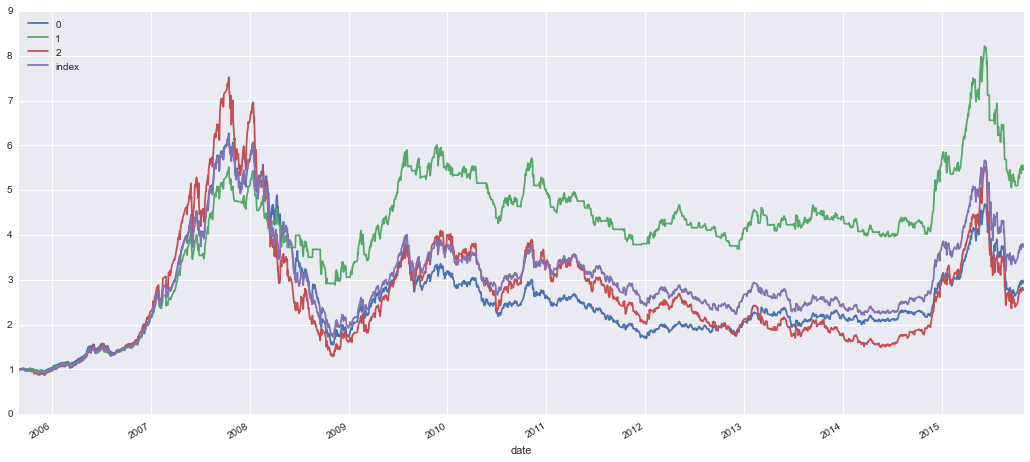

In [563]:
### 策略组
### 0: J>0买入， J<0卖出
### 1: J>0, K>30买入， J<0 , K<70卖出
### 2: K>30买入， K<70卖出

K, D, J, RSV_n, signal = KDJ(data)
signal_strategy = pd.DataFrame()
signal_strategy['0'] = (J>0)*1 + (J<0)*-1
signal_strategy['1'] = ((J > 0)& (K > 30))*1 + ((J<0)&(K < 70)) * -1
signal_strategy['2'] = (K > 30)*1 - (K < 70)*-1
signal_strategy['index'] = 1


ret_strategy = ret['cc'] * signal_strategy.shift(1)
ret_strategy = ret_strategy.dropna()

(1+ret_strategy).cumprod().plot()
                
#pf.create_full_tear_sheet(ret_strategy['1'], benchmark_rets=ret['cc'])

### 测试0: 光大KDJ优化参数
我们这里根据光大证券发布的《技术指标系列（1）－KDJ优化策略》里面描述的KDJ交易方法，进行了模拟：
* 当 K 上穿 30 时,买入,信号为 1
* 当 K 下穿 70 时,卖空,信号为-1
* 当信号为 1 且 K 在 70 以下,K,D 产生死叉,反向做空,信号改为-1 当信号为-1 且 K 在 30 以上,K,D 产生金叉,反向做多,信号改为 1
* 当 K 大于 70 时,信号恒为 1

测试的交易净值曲线，与想象完全不同。 （怀疑我们的实现方法有误）

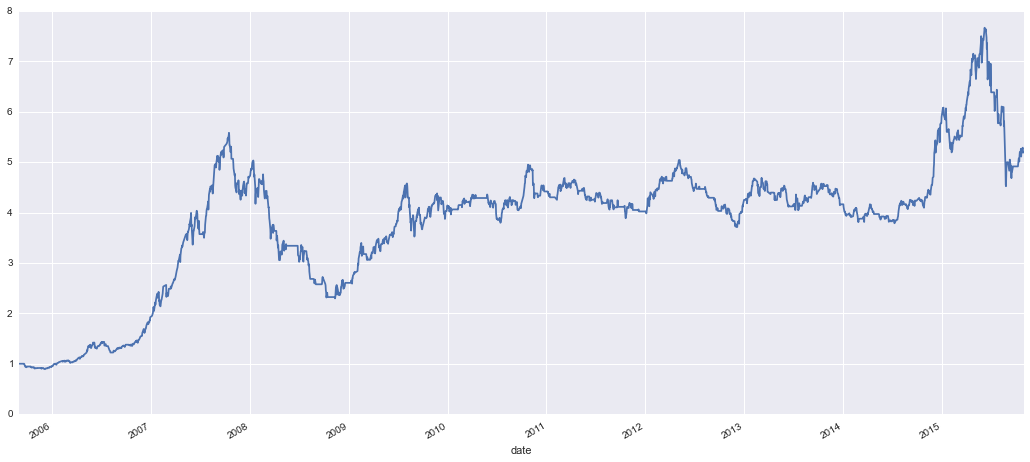

In [564]:
K, D, J, RSV_n, signal = KDJ(data, n = 10)
signal_pos = K*0;
signal_pos[np.isnan(signal_pos)] = 0
n = len(K)

for i in range(n-1) :
    signal_pos[i+1] = signal_pos[i];
    #print(signal_pos[i])
    if signal['uc_30'][i] == 1: ## 上穿30，买入
        signal_pos[i+1] = 1;
    if signal['dc_70'][i] == 1: ## 下穿70， 卖出 
        signal_pos[i+1] == 0;
    if signal_pos[i] == 1 and K[i] < 70 and signal['uc_KD'][i] == 1: ## K <70, 死叉卖空
        signal_pos[i+1] = 0;
    if signal_pos[i] == -1 and K[i] > 30 and signal['dc_KD'][i] == 1: ## K >30, 金叉买入
        signal_pos[i+1] = 1;
    if K[i] > 70:
        signal_pos[i+1] = 1;
    

ret_strategy = signal_pos.shift(1) * ret['cc']
(1+ret_strategy).cumprod().plot()
#pf.create_full_tear_sheet(ret_strategy, benchmark_rets=ret['cc'])

### 测试1： 基本测试
我们测试了各种情况：
1. K高于70时做多
2. K低于30时做空
3. K>D(金叉）做多
4. K<D(死叉）做空

收益显示: K高于70时做多， 收益回报最高（曲线1）。在K低于30时做空， 收益为正， 但是回报并不高（曲线2）。 而针对金叉死叉的判断，回报不稳定（曲线3，4）。 
所以可以判断针对K线与关键阀值（30，70）的交易信号是比较有效的。 与基准曲线index相对比，策略1有效的避免了2008-2009年股市大熊市的损失， 然后在最近的2015年的暴跌行情， 策略1却没有避免。 同时，策略1出入场信号交替频繁， 无效信号比较多。 

/Applications/anaconda/lib/python3.4/site-packages/pandas/core/frame.py:3200: FutureWarning: TimeSeries broadcasting along DataFrame index by default is deprecated. Please use DataFrame.<op> to explicitly broadcast arithmetic operations along the index
  FutureWarning)


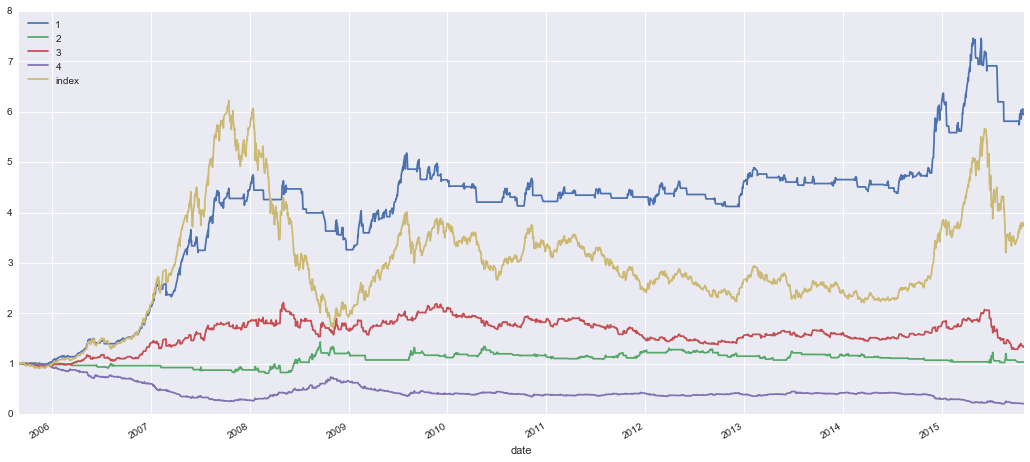

In [565]:
K, D, J, RSV_n, signal = KDJ(data, n=15)
signal_test2 = pd.DataFrame()
signal_test2['1'] = ((signal['K'] > 70))*1 ## 测试K>70,做多
signal_test2['2'] = ((signal['K'] < 30))*-1 ## K < 30, 做空
signal_test2['3'] = ((signal['K'] > signal['D']))*1 ## K>D, 做多
signal_test2['4'] = ((signal['K'] < signal['D']))*-1 ## K<D, 做多
#signal_test2['5'] = (signal['J'] > 50)*1
#signal_test2['6'] = (signal['J'] < 50)*1
signal_test2['index'] = 1

ret_strategy = signal_test2.shift(1)* ret['cc'] 
ret_strategy = ret_strategy.dropna()
(1+ret_strategy).cumprod().plot()

### 测试2: 组合测试
可以将策略1和2组合在一起（即在K线高于70时做多， 在高于30时做空），可以取得比策略1，2分别更好的结果。 

/Applications/anaconda/lib/python3.4/site-packages/pandas/core/frame.py:3200: FutureWarning: TimeSeries broadcasting along DataFrame index by default is deprecated. Please use DataFrame.<op> to explicitly broadcast arithmetic operations along the index
  FutureWarning)


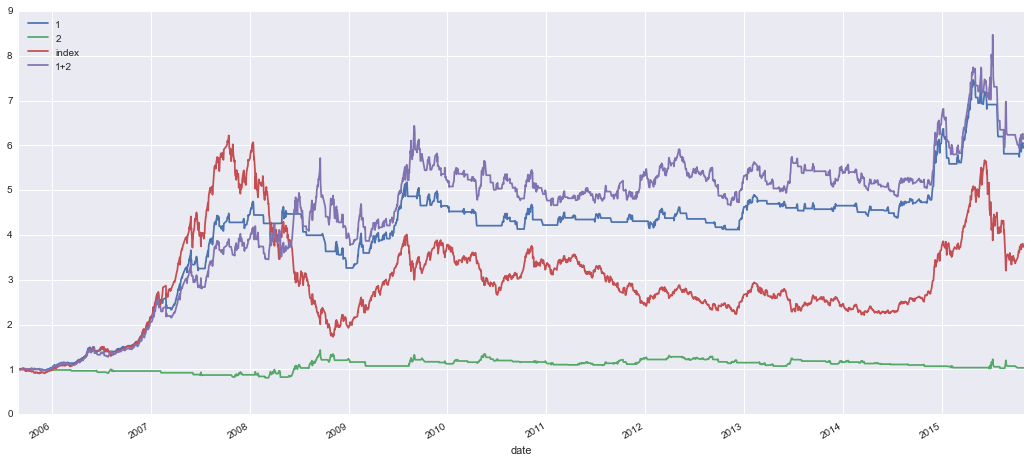

In [566]:
signal_test2['1+2'] = (signal_test2['1'] + signal_test2['2'])

list = [0, 1, 4, 5]
ret_strategy = ret['cc'] * signal_test2[list].shift(1)
ret_strategy = ret_strategy.dropna()
(1+ret_strategy).cumprod().plot()

### 测试3: 动态测试
这里我们选取了策略1和2的混合（即在K线高于70时做多， 在高于30时做空）， 作为目标策略进行优化。 该策略有如下参数可以调整：
* KDJ计算的n， 默认的n＝14。 参数的取值范围为（10， 50）
* 做多的阀值th_long = 70。参数范围（0， 100）
* 做空的阀值th_short = 30。 参数范围（0， 100）

首先我们采用不同的n来计算KDJ， 并观察策略回报

In [567]:
def KDJ_Optim_Strategy(data, n = 14, th_long = 70, th_short = 30) :
    K, D, J, RSV_n, signal = KDJ(data, n)
    signal_trade = pd.DataFrame()
    signal_trade['long'] = ((signal['K'] > th_long))*1 ## 测试K>70,做多
    signal_trade['short'] = ((signal['K'] < th_short))*-1 ## K < 30, 做空
    signal_trade['total'] = signal_trade['long'] + signal_trade['short']
    
    rets = ret['cc'] * signal_trade.shift(1)
    rets = rets.dropna()
    return rets;

/Applications/anaconda/lib/python3.4/site-packages/pandas/core/frame.py:3200: FutureWarning: TimeSeries broadcasting along DataFrame index by default is deprecated. Please use DataFrame.<op> to explicitly broadcast arithmetic operations along the index
  FutureWarning)


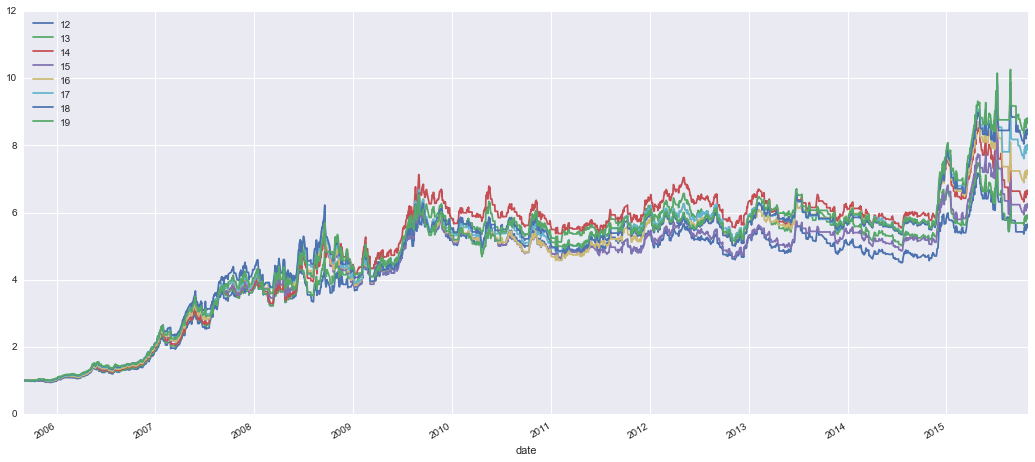

In [568]:
rets_test = pd.DataFrame();
for i in range(12, 20, 1) :
    rets = KDJ_Optim_Strategy(data, i )
    rets_test[i] = rets['total']
    
(1+rets_test).cumprod().plot()

/Applications/anaconda/lib/python3.4/site-packages/pandas/core/frame.py:3200: FutureWarning: TimeSeries broadcasting along DataFrame index by default is deprecated. Please use DataFrame.<op> to explicitly broadcast arithmetic operations along the index
  FutureWarning)


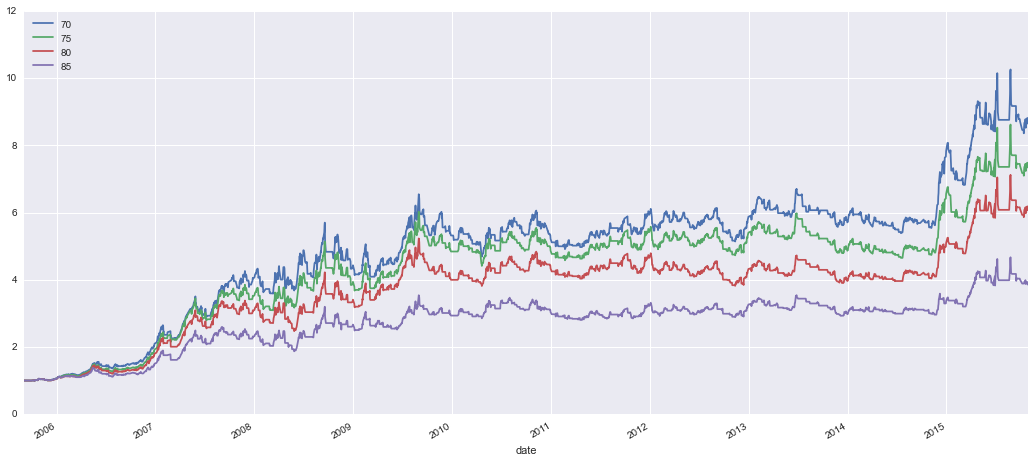

In [569]:
rets_test = pd.DataFrame();
for i in range(70, 90, 5) :
    rets = KDJ_Optim_Strategy(data, 19,th_long=i )
    rets_test[i] = rets['total']
    
(1+rets_test).cumprod().plot()

/Applications/anaconda/lib/python3.4/site-packages/pandas/core/frame.py:3200: FutureWarning: TimeSeries broadcasting along DataFrame index by default is deprecated. Please use DataFrame.<op> to explicitly broadcast arithmetic operations along the index
  FutureWarning)


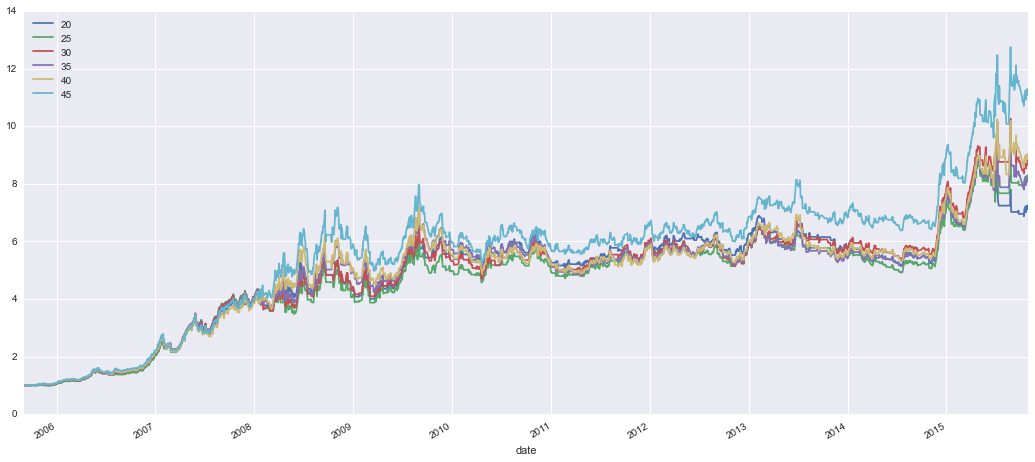

In [570]:
rets_test = pd.DataFrame();
for i in range(20, 50, 5) :
    rets = KDJ_Optim_Strategy(data, 19, th_short=i )
    rets_test[i] = rets['total']
    
(1+rets_test).cumprod().plot()

结果我们发现最佳的参数设置为（n＝19， th_long＝70， th_short＝30）

/Applications/anaconda/lib/python3.4/site-packages/pandas/core/frame.py:3200: FutureWarning: TimeSeries broadcasting along DataFrame index by default is deprecated. Please use DataFrame.<op> to explicitly broadcast arithmetic operations along the index
  FutureWarning)


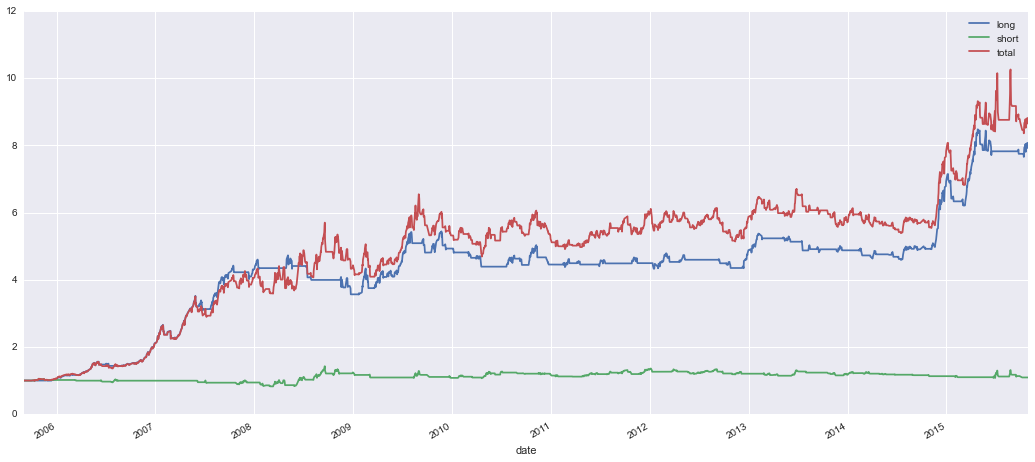

In [571]:
rets_best = KDJ_Optim_Strategy(data, 19)
(1+rets_best).cumprod().plot()

In [1]:
data

NameError: name 'data' is not defined